# Gaussians Arithmetic

This is a presentation for Computer Science Club having to do with Kalman filters.  This notebook has to do with showing that two critical aspects of arithmetic on Gaussian distributions, addition and multiplication, work as expected with sampled distributions.

## Basic Gaussian Generation And Plotting 

These are just two classes that wrap numpy's `np.random.normal` and matploblib's `hist` methods to make things easier.

In [159]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


class Plot:
    def __init__(self, range=(-20,20)):
        self.range = range 
    
    def hist(self, data, color):
        plt.hist(data, 200, range=self.range, normed=True, facecolor=color, alpha=0.2, histtype='stepfilled')
        
    def plot(self, x, y, color, alpha):
        plt.plot(x, y, color=color, alpha=alpha)

    def show(self):
        plt.show() 
        
        
class Gaussian:
    def samples(self, params, samples=2000):
        return [np.random.normal(params[0], params[1]) for x in range(samples)]
            
    def plot_samples(self, plot, params, color='green'):
        plot.hist(self.samples(params), color)
        
    def gaussian(self, x, mean, std):
        return np.exp(-1.0 * np.power((x - mean) / std, 2.0) / 2.0) / (math.sqrt(2.0 * math.pi) * std)
    
    def make_support(self, plot, scale=100.0):
        return [x / scale for x in range(int(scale * plot.range[0]), int(scale * plot.range[1]))]
        
    def plot_pdf(self, plot, params, color='green', alpha=1.0):
        support = self.make_support(plot)
        result = [self.gaussian(x, params[0], params[1]) for x in support]
        plot.plot(support, result, color, alpha)
     

### Plotting A Single Gaussian

Easy to plot a single distribution.

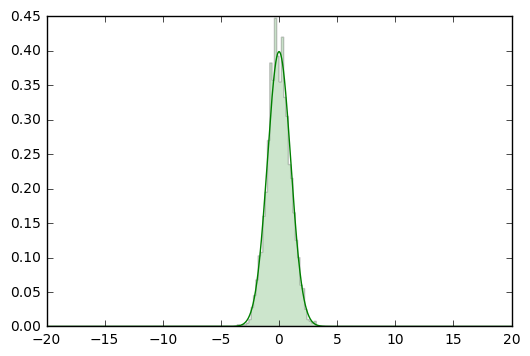

In [179]:
p = Plot()
g = Gaussian()

dist = (0.0, 1.0)

# Distribution histogram in green, with PDF outline
g.plot_samples(p, dist)
g.plot_pdf(p, dist)

p.show() 

### Plotting Multiple Gaussians

Easy enough to plot a couple distributions on the same plot in different colors.  We will be using these two distributions in the following calculations.

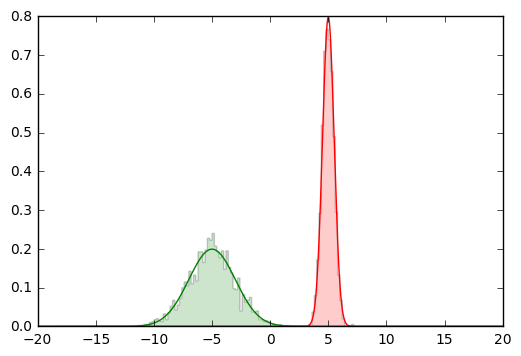

In [180]:
p = Plot()
g1, g2 = Gaussian(), Gaussian()

dist1 = (-5.0, 2.0)
dist2 = (5.0, 0.5)

# First distribution histogram in green, with PDF outline
g1.plot_samples(p, dist1)
g1.plot_pdf(p, dist1)

# Second distribution histogram in red, with PDF outline
g2.plot_samples(p, dist2, 'red')
g2.plot_pdf(p, dist2, 'red')

p.show() 

## Computing With Gaussian Distributions

Here we are validating that for IID Gaussians that the sum and product behave as expected.

In [122]:
class Compute:
    def add(self, dist1, dist2):
        mean = dist1[0] + dist2[0]
        std = dist1[1] + dist2[1]
        self.dist = (mean, std)
        
    def multiply(self, dist1, dist2):
        mean = (dist1[0] * dist2[1] + dist1[1] * dist2[0]) / (dist1[1] + dist2[1])
        std = 1.0 / (1.0 / dist1[1] + 1.0 / dist2[1])
        self.dist = (mean, std)
   

### Addition

The prediction step in a Kalman filter is a sum of Gaussians.  For addition, the pointwise addition of the samples suffices.  The green distribution is from the computed mean and standard deviation, the red distribution is from manually adding the points of the two Gaussians being summed.  The black line is the outline of the ideal distribution.  As you can see they are the same distribution.

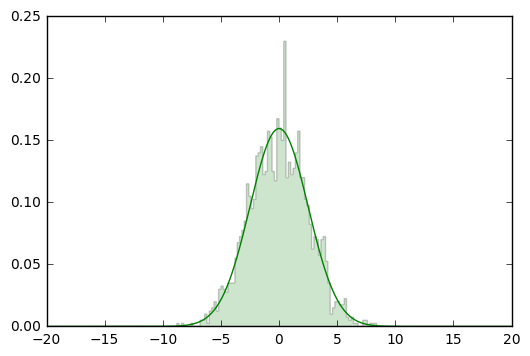

In [182]:
p = Plot()
g = Gaussian()
c = Compute()

dist1 = (-5.0, 2.0)
dist2 = (5.0, 0.5)

# The PDF as a green curve
c.add(dist1, dist2)
g.plot_pdf(p, c.dist)

# Histogram data in green using computed parameters
g.plot_samples(p, c.dist)

p.show() 

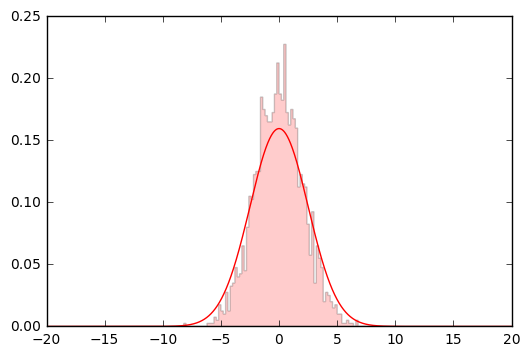

In [183]:
p = Plot()
g, g1, g2 = Gaussian(), Gaussian(), Gaussian()
c = Compute()

dist1 = (-5.0, 2.0)
dist2 = (5.0, 0.5)

# The PDF as a red curve
c.add(dist1, dist2)
g.plot_pdf(p, c.dist, 'red')

# Histogram data in red by actually summing the two priors
s1 = g1.samples(dist1)
s2 = g2.samples(dist2)
g_sum = [s1[i] + s2[i] for i in range(len(s1))]
p.hist(g_sum, 'red')               

p.show() 

### Multiplication

The measurement step in a Kalman filter is the product of Gaussians, related to the application of Bayes Theorem for the posterior and the measurement.  Please see [this link](../docs/Bromiley2014.pdf) and [this link](../docs/Roweis1999.pdf) for more information.  For this, we will simply plot the outline of the distribution rather than the sampled distribution to keep things simple. There are a few examples that we will look at.  

First, two priors with equal variance:

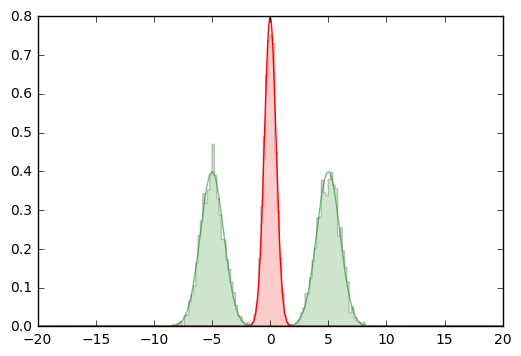

In [190]:
p = Plot()
g = Gaussian()
c = Compute()

dist1 = (-5.0, 1.0)
dist2 = (5.0, 1.0)

# Priors in green
g.plot_pdf(p, dist1, 'green', 0.5)
g.plot_samples(p, dist1, 'green')
g.plot_pdf(p, dist2, 'green', 0.5)
g.plot_samples(p, dist2, 'green')

# Posterior in red
c.multiply(dist1, dist2)
g.plot_pdf(p, c.dist, 'red')
g.plot_samples(p, c.dist, 'red')

p.show() 

Most interesting thing to note is that the variance of the posterior distribution is smaller than the two priors.  This tells us that when we compute the posterior we are making a more refined estimate of the mean.  In fact, if we have two distributions with the same variance, then we end up with a posterior having half the variance. 

Second, two priors with unequal variance:

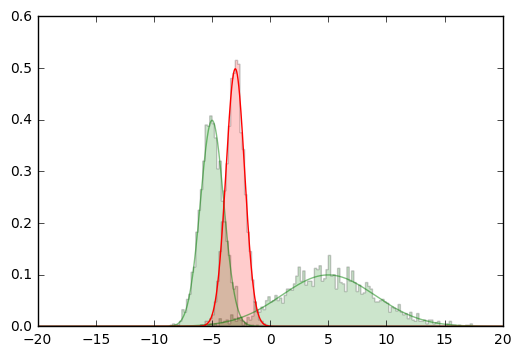

In [191]:
p = Plot()
g = Gaussian()
c = Compute()

dist1 = (-5.0, 1.0)
dist2 = (5.0, 4.0)

# Priors in green
g.plot_pdf(p, dist1, 'green', 0.5)
g.plot_samples(p, dist1, 'green')
g.plot_pdf(p, dist2, 'green', 0.5)
g.plot_samples(p, dist2, 'green')

# Posterior in red
c.multiply(dist1, dist2)
g.plot_pdf(p, c.dist, 'red')
g.plot_samples(p, c.dist, 'red')

p.show() 

In this case, the posterior still has benefit in terms of variance, but the magnitude of benefit is smaller.  As well, note that the mean is weighted toward the distribution of smaller variance. 

Lastly, a case with the same mean and fairly dissimilar variance:

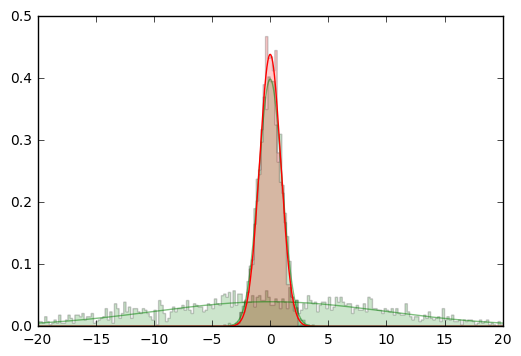

In [195]:
p = Plot()
g = Gaussian()
c = Compute()

dist1 = (0.0, 1.0)
dist2 = (0.0, 8.0)

# Priors in green
g.plot_pdf(p, dist1, 'green', 0.5)
g.plot_samples(p, dist1, 'green')
g.plot_pdf(p, dist2, 'green', 0.5)
g.plot_samples(p, dist2, 'green')

# Posterior in red
c.multiply(dist1, dist2)
g.plot_pdf(p, c.dist, 'red')
g.plot_samples(p, c.dist, 'red')

p.show() 

It is a bit hard to see the green figure with the lower variance, but what we can see here is that the limiting distribution is simply the prior with the lowest variance.  The thing to keep in mind is that as we keep applying this, we keep moving towards the lowest variance, and we are always improving the estimate with the new information we are exposed to. 